# E07 Sistema de Recomendação usando Word2Vec

Neste exercício você irá desenvolver um sistema de recomendação usando _embeddings_ criados com Word2Vec. A partir de uma base de dados de _e-commerce_ onde estão registradas as compras de um site de vendas pela internet, vamos avaliar quais mercadorias foram compradas juntamente a quais outras mercadorias. O pressuposto aqui é que quando o cliente realiza uma compra online, ele possui um interesse temático em mente e acaba comprando itens que se correlacionam de alguma forma. Ainda que em alguns casos possam ser incluídos itens menos relacionados, em sua vasta maioria assumimos que as compras seguem algum tipo de correlação entre si. Por exemplo, um cliente pode estar fazendo compras para organizar uma festa infantil ou uma viagem, e de acordo com esse interesse, acaba comprando itens relacionados a essas atividades.

Sendo assim, neste exercício, nosso interesse estará em tentar criar um embedding usando o algoritmo Word2Vec, usando como contexto de vizinhança a sequência de produtos comprados por um mesmo cliente em uma específica nota fiscal. Cada ordem de compra (carrinho de compras) vai conter uma lista de produtos, e os códigos de identificação destes produtos serão nossas "palavras", sendo que a sequência de produtos comprados formam as "frases" para nosso treinamento.

Como neste exercício usaremos a biblioteca _gensim_, você perceberá que a parte mais trabalhosa do exercício estará na preparação dos dados, já que a ferramenta que cria o _embedding_ já estará pronta para uso. Então nesse exercício, você ficara encarregado da preparação dos dados.

Para resolver o exercício, siga os passos, lendo as instruções e comentários, um a um, e preenchendo código onde for requisitado.

## Passo 1: Baixar Dados

Aqui usaremos uma planilha do Microsoft Excel com dados de compras de usuários em um sistema de varejo. O nome do arquivo é `retail.xlsx`.

In [3]:
# O comando abaixo baixa o arquivo correspondente a essa planilha
# do Excel para o computador remoto do Google Colab.

!gdown https://drive.google.com/uc?id=1NK-2z0l-qTplDJJ2SHpTVBGRP3zWAK-n

Downloading...
From: https://drive.google.com/uc?id=1NK-2z0l-qTplDJJ2SHpTVBGRP3zWAK-n
To: /content/retail.xlsx
100% 23.7M/23.7M [00:00<00:00, 29.3MB/s]


Usaremos a biblioteca `pandas` para fazer a leitura dos dados

In [4]:
import pandas as pd

Aqui fazemos a leitura dos dados para um objeto `DataFrame` do `pandas`.

In [5]:
# Esta linha de código pode demorar cerca de 1 min para rodar
df = pd.read_excel('retail.xlsx')

Agora podemos observar os dados para entender como estão organizados.

In [6]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


A tabela acima mostra a estrutura da planilha. Podemos observar os campos:

- **InvoiceNo**: Este é um identificador único para cada compra.
- **StockCode**: Identificador único para cada produto.
- **Description**: Descrição do produto.
- **Quantidade**: Quantidade daquele produto, naquela compra.
- **InvoiceDate**: Dia e hora da compra.
- **CustomerID**: Identificador único do cliente.

In [7]:
df.shape

(541909, 8)

Acima vemos que essa base de dados possui 541.909 registros. Cada registro representa uma linha, ou seja, um produto comprado (cuja quantidade pode ser maior que 1). Diferentes linhas podem representar diferentes itens de uma mesma compra.

## Passo 2: Remoção de Dados Nulos

Neste passo vamos remover da base de dados os dados relativos a compras de produtos onde algum dos dados de interesse estejam faltando.

Começamos observando a quantidade de dados nulos

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Acima podemos observar há 1.454 registros sem a descrição do produto, e 135.080 registros sem a identificação do cliente comprador.

No código abaixo você deve remover todos os registros onde aparece pelo menos um dos campos nulos. Para entender como fazer isso, veja esse trecho da videoaula sobre pandas (especificamente a partir de 19m41s no vídeo, até mais ou menos 21m).



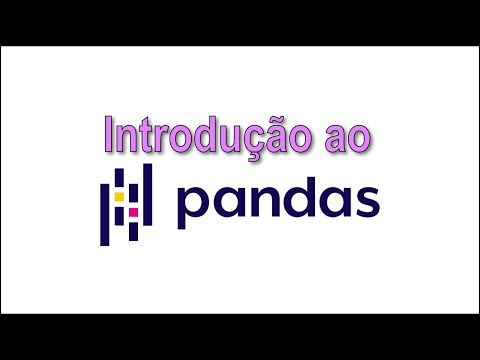

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('usmbTUx9zdY', start=1181)

In [10]:

df.dropna(inplace=True)


In [11]:


df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Passo 3: Dicionário de Produtos

Agora vamos preparar um dicionário de códigos e respectivas descrições dos produtos. Esse dicionário servirá para que nós, humanos, possamos inspecionar o resultado de nossas operações no _embedding_, já que o _embedding_ vai ser treinado com base nos códigos dos produtos. Como os códigos não permitem inspeção intuitiva da natureza de cada produto, vamos precisar desse dicionário para entender qual é a descrição do produto correspondente a cada código.

### Passo 3.1: Conversão dos Códigos para Strings

Começamos convertendo os códigos de produto (coluna **StockCode**) para string, para usar como "palavras" no treinamento de um modelo word2vec no `gensim` mais tarde.

Para fazer isso você pode usar o método `.astype(tipo)` do pandas. Com esse comando, você consegue converter uma coluna específica do DataFrame para o tipo de dado que quiser. Por exemplo, se tivéssemos um DataFrame `d` com uma coluna chamada `idade` no formato `int` e se quiséssemos converter para o formato `float`, bastaria executar o comando:

`# Converte idade para float`

`d['idade'] = d['idade'].astype(float)`

No nosso caso, queremos transformar o campo `StockCode` do DataFrame `df` para o formato string (`str`). Após a alteração, os elementos da coluna `StockCode` de `df` deverão ser strings.


In [12]:


df['StockCode'] = df['StockCode'].astype(str)


### Passo 3.2

Agora criaremos um novo _DataFrame_, de nome `products`. Selecionaremos apenas as colunas `StockCode` e `Description` do _DataFrame_ original, `df`.

Para entender como selecionar colunas específicas, veja o vídeo abaixo a partir de 21m07s até 21m35s.

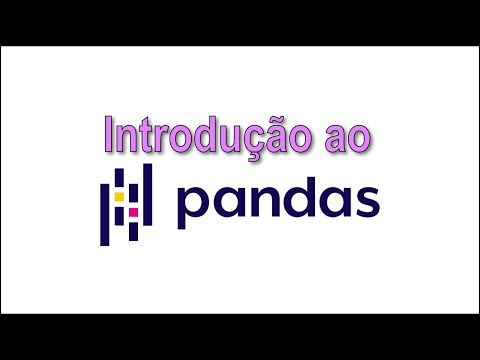

In [11]:
YouTubeVideo('usmbTUx9zdY', start=1267)

Escreva seu código abaixo, criando o `DataFrame` de nome `products` que seleciona apenas as colunas `StockCode` e `Description`.

In [13]:


products = df[['StockCode', 'Description']].copy()


### Passo 3.3 Remoção de Itens Duplicados

Obviamente muitos produtos foram comprados mais de uma vez. Em nosso dicionário de códigos e descrições, como a finalidade é simplesmente identificar a descrição que corresponde a um determinado código, então não faz sentido ter itens duplicados.

No código abaixo faça uma remoção de todas entradas onde o código do produto (coluna `StockCode`) seja duplicado.

Para entender como fazer isso, veja o vídeo abaixo a partir de 21m41s até 22m10s.

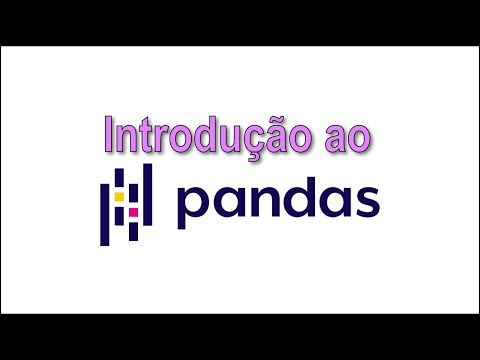

In [14]:
YouTubeVideo('usmbTUx9zdY', start=1301)

In [15]:


products.drop_duplicates(subset='StockCode', keep='first', inplace=True)


### Passo 3.4 Criação do Dicionário

Agora você vai criar um dicionário nativo do Python, onde as chaves serão os códigos dos produtos (`StockCode`) e os valores serão as respectivas strings de descrição (`Description`).

Para entender como converter este DataFrame em um dicionário, assista o vídeo abaixo, a partir de 22min35s até 23min03s.

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1355)

In [16]:

products_dict = products.set_index('StockCode')['Description'].to_dict()



In [17]:


products_dict['84029E']

'RED WOOLLY HOTTIE WHITE HEART.'

## Passo 4: Preparação dos Dados

Neste passo vamos preprarar os dados transformando o histórico de compras de cada consumidor numa espécie de "frase", onde cada "palavra" é um produto comprado.

### Passo 4.1: Contagem dos Clientes Únicos

Nesta base de dados temos o registro de cada compra de cada cliente ao longo de um ano. Isso significa que não apenas podemos ter o mesmo produto sendo comprado por diferentes clientes, mas também teremos o mesmo cliente, fazendo diferentes compras em diferentes momentos.

Para avaliar nosso sistema de forma mais justa e próxima de um uso real, vamos tentar separar dados de validação e dados de treinamento de forma que não usemos compras de um mesmo cliente nos dados de validação e nos dados de treinamento (mesmo que em momentos diferentes). Em outras palavras, vamos separar _todas as compras_ de certos clientes para treinamento e _todas as compras_ de certos outros clientes para validação, ou seja, a separação será pelo cliente que realizou a compra. Assim todas compras de um determinado cliente estarão exclusivamente nos dados de validação ou exclusivamente nos dados de treinamento, nunca em ambos. Isso servirá para que possamos avaliar se o sistema de recomendação funciona, mesmo quando treinado para clientes diferentes daqueles para os quais estamos recomendando no momento: quer dizer que podemos treinar o sistema com as compras dos clientes escolhidos para o grupo de treinamento e avaliar as recomendações num grupo de clientes que o sistema nunca viu antes.

Para fazer isso, seria interessante começar confirmando exatamente quantos clientes únicos temos nessa base de dados.

A partir do DataFrame `df` selecione a coluna `CustomerID` e usando os métodos `unique()` e a conversão `tolist()`, gere uma lista com todos os ids de clientes únicos. Essa lista deverá se chamar `customers`.

O vídeo abaixo, a partir de 23m59s até 25m16s, mostra como isso pode ser feito.

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1439)

In [18]:


customers = df['CustomerID'].unique().tolist()


In [19]:
len(customers)

4372

Se tudo deu certo até aqui, então verificamos que há exatamente 4.372 clientes na nossa base de dados. Para cada um desses clientes vamos verificar o histórico de compras, criando 4.372 sequências de compras.

### Passo 4.2: Embaralhamento dos Dados

Agora escreva código para embaralhar a ordem dos ids dos clientes na lista `customers`, usando o método `shuffle`. O resultado deve estar na própria variável `customers` (não mude o nome da variável).

In [20]:

import random
random.shuffle(customers)



### Passo 4.3: Separação dos Dados de Treinamento e Validação

Agora vamos separar dados de treinamento e de validação. Vamos separar 10% dos dados para validação e 90% dos dados para treinamento. Mas esses percentuais serão separados em termos de clientes. Isso significa que faremos o seguinte:

1. Definiremos uma lista de clientes de treinamento, contendo 90% dos itens da variável `customers`. Vamos chamar essa variável de `customers_train`.
2. Definiremos uma lista de clientes de validação, contendo 10% dos itens da variável `customers`. Vamos chamar essa variável de `customers_val`.
3. Em nosso dataset `df`, selecionaremos todas as linhas onde o campo `CustomerID` contenha um código de cliente presente na lista `customers_train`. Essa seleção será um novo dataset de nome `df_train`.
4. Faremos o mesmo com os  dados de validação,  selecionando as linhas de `df` onde `CustomerID` está contido em `customers_val`. Essa seleção chamaremos de `df_val`.

Dica: para os passos 3 e 4 acima, use o método `.isin(nome_da_lista)`. Veja o vídeo abaixo a partir de 25m19s até o final do vídeo.



In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1519)

In [21]:

percentagem_treinamento = 0.9
train_size = int(len(customers) * percentagem_treinamento)


customers_train = customers[:train_size]
customers_val = customers[train_size:]


df_train = df[df['CustomerID'].isin(customers_train)]
df_val = df[df['CustomerID'].isin(customers_val)]

### Passo 4.4: Função que compila sequência de compras de cada cliente.

Com essas listas de clientes criamos abaixo as sequências de compras de acordo com os históricos de cada cliente.

In [22]:
def compile_orders(customers, df):
  ''' Essa função coleta todas compras do histórico
      de cada cliente. O parâmetro customers é a lista
      de ids de clientes e o parâmetro df é o objeto
      DataFrame do pandas com os dados de cada compra.
      O valor retornado é uma lista de listas, onde cada
      lista interna contém a seguência de códigos de produto
      de cada compra, na ordem que se apresentava no
      histórico.
  '''

  # Essa será a lista de compras -- lista de listas de produtos
  orders = []

  # Coletaremos as compras de cada cliente
  for customer in customers:

    # Aqui convertemos os códigos de produtos das compras
    # de cada cliente para uma lista única
    order = df[df['CustomerID'] == customer]['StockCode'].tolist()

    # Essa lista de itens será a lista de produtos que será adicionada
    # à lista de compras principal.
    orders.append(order)

  return orders

In [23]:
# Aqui separamos as listas de listas de compras. Este código
# demora cerca de 1 minuto para rodar
orders_train = compile_orders(customers_train, df_train)
orders_val = compile_orders(customers_val, df_val)

## Passo 5: Treinar o Embedding Word2Vec

Esta é a última etapa, onde utilizamos a lista de compras (lista de listas com códigos de produtos) para treinar nosso embedding. Essa lista de listas funcionará de forma análoga a uma lista de frases, onde cada frase é uma lista de palavras: lista de listas de palavras. A diferença é que aqui as strings que seriam palavras foram substituídas por códigos de produtos.

In [24]:

import gensim

import numpy as np


import warnings;
warnings.filterwarnings('ignore')

In [26]:

model = gensim.models.Word2Vec(orders_train, \
                               vector_size=50, \
                               window=5, \
                               workers=10, \
                               epochs=10)

In [27]:


print(model)

Word2Vec<vocab=3178, vector_size=50, alpha=0.025>


## Passo 5: Resultados

Finalmente podemos agora examinar como ficou o resultado.

### Passo 5.1: Produtos semelhantes

Para facilitar nossos testes, definimos abaixo uma função que retorna os 10 produtos mais semelhantes a um produto específico, passado como argumento.

In [28]:
def most_similar(product_id):
  ''' Essa função mostra os 10 produtos mais semelhantes
      ao produto cujo código foi passado como argumento.
      Na verdade o método most_similar() do objeto Word2Vec
      já faz isso. Aqui apenas acrescentamos as descrições,
      para facilitar examinar o resultado, já que olhando
      apenas os códigos ficaria difícil de dizer se o
      conjunto de produtos semelhantes faz sentido.
  '''

  # Primeiro mostramos a descrição do produto consultado
  print('Most similar to:', products_dict[product_id])

  # Aqui buscamos a lista de códigos mais semelhantes
  # ao apresentado no embedding.
  s = model.most_similar(positive=product_id)

  # Para cada código, mostramos a descrição
  for product, prob in s:
    print(products_dict[product], prob)

In [30]:
model.wv.index_to_key[1000:1010]

['23093',
 '22594',
 '22544',
 '22848',
 '23345',
 '22421',
 '22732',
 '22843',
 '23407',
 '22494']

In [31]:
products_dict.keys()

dict_keys(['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632', '84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755', '21777', '48187', '22960', '22913', '22912', '22914', '21756', '22728', '22727', '22726', '21724', '21883', '10002', '21791', '21035', '22326', '22629', '22659', '22631', '22661', '21731', '22900', '21913', '22540', '22544', '22492', 'POST', '22086', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '21258', '22114', '21733', '22386', '85099C', '21033', '20723', '84997B', '84997C', '21094', '20725', '21559', '22352', '21212', '21975', '21977', '84991', '84519A', '85183B', '85071B', '21931', '21929', '22961', '22139', '84854', '22411', '82567', '21672', '22774', '22771', '71270', '22262', '22637', '21934', '21169', '21166', '21175', '37444A', '37444C', '22083', '84971S', '47580', '22261', '84832', '22644', '21533', '21557', '15056BL', '15056N', '22646', '22176', '22438', '

In [34]:
# Aqui vamos verificar o produto mais semelhante
# ao produto de código 23188.

model.wv.most_similar('23188')

[('22992', 0.7740505337715149),
 ('23190', 0.761854887008667),
 ('23552', 0.7328079342842102),
 ('23498', 0.731248140335083),
 ('23192', 0.7161716818809509),
 ('23497', 0.7111896276473999),
 ('22991', 0.7098292708396912),
 ('23570', 0.7095364928245544),
 ('23117', 0.6776599287986755),
 ('23569', 0.6697975397109985)]

## Passo 5.2: Sugestão de produtos

Agora sim, podemos fazer nosso sistema de sugestões de compras. Na variável orders_val temos os conjuntos de itens em cada compra, de cada cliente. Por exemplo, abaixo, podemos listar as compras da ordem número 32, no código abaixo:

In [35]:
# Lista os códigos dos produtos comprados
# na ordem de compras número 32.

orders_val[32]

['21576',
 '21577',
 '22379',
 '20727',
 '21930',
 '20711',
 '22555',
 '22554',
 '22385',
 '22380',
 '22553',
 '22149',
 '22621',
 '22610',
 '21637',
 '22094',
 '21980',
 '21982',
 '21967',
 '22616',
 '22093',
 '22384',
 '22383',
 '20725',
 '85099B',
 '21770',
 '20886',
 '22693',
 '20972',
 '20728',
 '22379',
 '22384',
 '20727']

Para sugerir compras, basta recuperarmos os vetores de embedding de cada um desses itens de uma ordem de compra, calcular um vetor médio (soma todos vetores e divide pela quantidade) e buscar os produtos mais semelhantes, como fizemos antes!

In [38]:
def get_suggestions(orders):
  ''' Nesta função, passa-se como argumento uma lista
      de códigos de produtos, que representa as compras
      de um cliente, em um determinado momento. Com base
      nos embeddings desses itens, calculamos um vetor
      médio, que captura a "semântica" das compras e
      baseado nesse vetor, buscamos os produtos mais
      similares para sugerir. Apenas sugerimos os
      produtos que já não estiverem na lista.
  '''
  # Esse será o array que armazenará o embedding médio
  v = np.zeros((50))

  # Essa variável vai receber a quantidade de produtos,
  # para calcular a média mais tarde.
  count = 0

  # Aqui mostramos as descrições dos produtos já na lista
  # para facilitar a conferência.
  print('Orders so far:')
  for product in orders:
    print(products_dict[product])
    # Para cada produto no embedding (aqui testamos,
    # para evitar incluir um produto que não esteja
    # no embedding treinado, pois isso geraria um erro)
    if product in model.wv:
      # somamos o vetor de embedding daquele produto
      # no array v
      v += model.wv[product]
      # e contamos +1 em count
      count += 1
  # Dividmos o resultado por count para calcular
  # o vetor médio, no espaço de embeddings
  v /= count
  # E por fim buscamos os 10 produtos mais semelhantes
  # como fizemos originalmente.
  s = model.wv.similar_by_vector(v)
  print('Suggestions:')
  for product, prob in s:
    # Mostramos apenas os produtos que já não estiverem
    # na lista original.
    if product not in orders:
      # Mostramos as descrições para facilitar a leitura
      print(products_dict[product], prob)

Abaixo testamos o código de sugestões definido acima.

In [39]:
get_suggestions(orders_val[32])

Orders so far:
LETS GO SHOPPING COTTON TOTE BAG
SAVE THE PLANET COTTON TOTE BAG
RECYCLING BAG RETROSPOT 
LUNCH BAG  BLACK SKULL.
JUMBO STORAGE BAG SKULLS
JUMBO BAG TOYS 
PLASTERS IN TIN STRONGMAN
PLASTERS IN TIN WOODLAND ANIMALS
JUMBO BAG SPACEBOY DESIGN
TOY TIDY SPACEBOY  
PLASTERS IN TIN SKULLS
FELTCRAFT 6 FLOWER FRIENDS
TRADITIONAL KNITTING NANCY
PENS ASSORTED FUNNY FACE
ASSORTED SANSKRIT MINI NOTEBOOK
RED RETROSPOT TISSUE BOX
PACK OF 12 RED RETROSPOT TISSUES 
PACK OF 12 SUKI TISSUES 
PACK OF 12 SKULL TISSUES
PACK OF 12 LONDON TISSUES 
MOTORING TISSUE BOX
LUNCH BAG PINK POLKADOT
LUNCH BAG SUKI  DESIGN 
LUNCH BAG RED RETROSPOT
JUMBO BAG RED RETROSPOT
OPEN CLOSED METAL SIGN
BOX OF 9 PEBBLE CANDLES
GROW A FLYTRAP OR SUNFLOWER IN TIN
PINK CREAM FELT CRAFT TRINKET BOX 
LUNCH BAG CARS BLUE
RECYCLING BAG RETROSPOT 
LUNCH BAG PINK POLKADOT
LUNCH BAG  BLACK SKULL.
Suggestions:
LUNCH BAG SPACEBOY DESIGN  0.8140019774436951
LUNCH BAG WOODLAND 0.7801585793495178
JUMBO STORAGE BAG SUKI 0.7244214

In [40]:
get_suggestions(orders_val[67])

Orders so far:
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
BROCADE RING PURSE 
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
BROCADE RING PURSE 
Suggestions:
ASSORTED CREEPY CRAWLIES 0.8378415703773499
SPACE FROG 0.8130195140838623
NINJA RABBIT BLACK 0.7948307991027832
SPACE CADET WHITE 0.7936534881591797
DINOSAUR KEYRINGS ASSORTED 0.7887260913848877
CHOCOLATE CALCULATOR 0.7824564576148987
NINJA RABBIT PINK 0.780421793460846
ASSORTED TUTTI FRUTTI HEART BOX 0.7802956700325012
SPACE CADET RED 0.7799834609031677


In [41]:
get_suggestions(orders_val[88])

Orders so far:
REGENCY CAKESTAND 3 TIER
ROSES REGENCY TEACUP AND SAUCER 
SWEETHEART CAKESTAND 3 TIER
WHITE HANGING HEART T-LIGHT HOLDER
LANTERN CREAM GAZEBO 
HEART OF WICKER LARGE
HEART OF WICKER SMALL
CERAMIC CAKE STAND + HANGING CAKES
MINI CAKE STAND WITH HANGING CAKES
CERAMIC CAKE DESIGN SPOTTED MUG
SET OF 3 CAKE TINS PANTRY DESIGN 
RECIPE BOX PANTRY YELLOW DESIGN
IVORY DINER WALL CLOCK
NO SINGING METAL SIGN
WASHROOM METAL SIGN
ASSORTED EASTER GIFT TAGS
RECIPE BOX PANTRY YELLOW DESIGN
MINI CAKE STAND WITH HANGING CAKES
ROSES REGENCY TEACUP AND SAUCER 
BISCUIT TIN VINTAGE RED
ROUND CAKE TIN VINTAGE GREEN
ROUND CAKE TIN VINTAGE RED
DOORMAT NEW ENGLAND
WHITE BROCANTE SOAP DISH
LANTERN CREAM GAZEBO 
SET OF 3 CAKE TINS PANTRY DESIGN 
VINTAGE CREAM DOG FOOD CONTAINER
VINTAGE CREAM CAT FOOD CONTAINER
VINTAGE SNAKES & LADDERS
PICTURE DOMINOES
VINTAGE SNAP CARDS
S/6 WOODEN SKITTLES IN COTTON BAG
TRADITIONAL WOODEN CATCH CUP GAME 
PACK OF 6 PANNETONE GIFT BOXES
CARD CIRCUS PARADE
ELEPHANT, BI